# CatBoost basics

For this homework will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

As a result of this tutorial you need to provide a tsv file with answers.
There are 17 questions in this tutorial. The resulting tsv file should consist of 17 lines, each line should contain the number of the question, an answer to it and a tab separater between them. Questions are numbered from 1 to 17.
See an example of the resulting file here.

## Reading the data

Let's first download the data and put it to folder `amazon`. Now we will read this data from file.

In [103]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import datasets
from catboost import *

from grader_v2 import Grader

In [104]:
train_df, test_df = catboost.datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [105]:
grader = Grader()

## Preparing your data

Label values extraction

In [106]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [107]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Now it makes sense to ananyze the dataset.
First you need to calculate how many positive and negative objects are present in the train dataset.

In [108]:
y.value_counts()[1]

30872

**Question 1:**

How many negative objects are present in the train dataset X?

In [109]:
zero_count = y.value_counts()[0]
grader.submit_tag('negative_samples', zero_count)

Current answer for task negative_samples is: 1897


**Question 2:**

How many positive objects are present in the train dataset X?

In [110]:
one_count = y.value_counts()[1]
grader.submit_tag('positive_samples', one_count)

Current answer for task positive_samples is: 30872


In [111]:
print('Zero count = ' + str(zero_count) + ', One count = ' + str(one_count))

Zero count = 1897, One count = 30872


Now for every feature you need to calculate number of unique values of this feature.

In [112]:
X.nunique()

RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

**Question 3:**
    
How many unique values has feature RESOURCE?

In [113]:
unique_vals_for_RESOURCE = X.nunique()['RESOURCE']
grader.submit_tag('resource_unique_values', unique_vals_for_RESOURCE)

Current answer for task resource_unique_values is: 7518


Now we can create a Pool object. This type is used for datasets in CatBoost. You can also use numpy array or dataframe. Working with Pool class is the most efficient way in terms of memory and speed. We recommend to create Pool from file in case if you have your data on disk or from FeaturesData if you use numpy.

In [114]:
import numpy as np
from catboost import Pool

pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(data='/opt/conda/lib/python3.6/site-packages/catboost/cached_datasets/amazon/train.csv', delimiter=',', has_header=True)
pool3 = Pool(data=X, cat_features=cat_features)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape)  + '\ndataset 3:' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1: ')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)


Column names
dataset 1: 
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

When you will be training your model, you will have to detect overfitting and select best parameters. To do that you need to have a validation dataset.
Normally you would be using some random split, for example
`train_test_split` from `sklearn.model_selection`.
But for the purpose of this homework the train part will be the first 80% of the data and the evaluation part will be the last 20% of the data.

In [115]:
train_count = int(X.shape[0] * 0.8)

X_train = X.iloc[:train_count,:]
y_train = y[:train_count]
X_validation = X.iloc[train_count:, :]
y_validation = y[train_count:]

## Train your model

Now we will train our first model.

In [116]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=0,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'random_seed': 0, 'loss_function': 'Logloss', 'learning_rate': 0.1, 'iterations': 5}


## Stdout of the training

You can see in stdout values of the loss function on each iteration, or on each k-th iteration.
You can also see how much time passed since the start of the training and how much time is left.

In [117]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    verbose=3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 184ms	remaining: 2.58s
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.69s	remaining: 4.64s
6:	learn: 0.1706950	test: 0.1549520	best: 0.1549520 (6)	total: 2.98s	remaining: 3.41s
9:	learn: 0.1672391	test: 0.1495040	best: 0.1495040 (9)	total: 4.08s	remaining: 2.04s
12:	learn: 0.1645499	test: 0.1487789	best: 0.1487789 (12)	total: 5.49s	remaining: 845ms
14:	learn: 0.1630092	test: 0.1469375	best: 0.1469375 (14)	total: 6.58s	remaining: 0us

bestTest = 0.1469374586
bestIteration = 14



## Random seed

If you don't specify random_seed then random seed will be set to a new value each time.
After the training has finished you can look on the value of the random seed that was set.
If you train again with this random_seed, you will get the same results.

In [118]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 70.9ms	remaining: 284ms
1:	learn: 0.2161146	test: 0.2152075	best: 0.2152075 (1)	total: 669ms	remaining: 1s
2:	learn: 0.1879597	test: 0.1797290	best: 0.1797290 (2)	total: 970ms	remaining: 647ms
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.57s	remaining: 394ms
4:	learn: 0.1732668	test: 0.1581682	best: 0.1581682 (4)	total: 2.17s	remaining: 0us

bestTest = 0.1581682309
bestIteration = 4



In [119]:
random_seed = model.random_seed_
print('Used random seed = ' + str(random_seed))
model = CatBoostClassifier(
    iterations=5,
    random_seed=random_seed
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Used random seed = 0
0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 189ms	remaining: 757ms
1:	learn: 0.2161146	test: 0.2152075	best: 0.2152075 (1)	total: 699ms	remaining: 1.05s
2:	learn: 0.1879597	test: 0.1797290	best: 0.1797290 (2)	total: 1.09s	remaining: 729ms
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.69s	remaining: 423ms
4:	learn: 0.1732668	test: 0.1581682	best: 0.1581682 (4)	total: 2.29s	remaining: 0us

bestTest = 0.1581682309
bestIteration = 4



Try training 10 models with parameters and calculate mean and the standart deviation of Logloss error on validation dataset.

**Question 4:**

What is the mean value of the Logloss metric on validation dataset (X_validation, y_validation) after 10 times training `CatBoostClassifier` with different random seeds in the following way:

`model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    random_seed={my_random_seed}
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)
`

In [52]:
print(np.squeeze(list(model.best_score_['validation_0'].values())))

0.1377092210691794


In [54]:
loglosses=[]
for i in range(10):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        random_seed=i*33,
        verbose=50
    )
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_validation, y_validation),
    )
    print(model.best_iteration_)
    print(model.best_score_)
    loglosses.append(np.squeeze(list(model.best_score_['validation_0'].values())))
    

0:	learn: 0.5790122	test: 0.5797377	best: 0.5797377 (0)	total: 97.5ms	remaining: 29.2s
50:	learn: 0.1606281	test: 0.1432391	best: 0.1432391 (50)	total: 24.1s	remaining: 1m 57s
100:	learn: 0.1555506	test: 0.1394226	best: 0.1394226 (100)	total: 46s	remaining: 1m 30s
150:	learn: 0.1515049	test: 0.1384309	best: 0.1384019 (148)	total: 1m 13s	remaining: 1m 12s
200:	learn: 0.1486424	test: 0.1381162	best: 0.1381162 (200)	total: 1m 41s	remaining: 49.9s
250:	learn: 0.1467162	test: 0.1379267	best: 0.1379267 (250)	total: 2m 10s	remaining: 25.4s
299:	learn: 0.1452004	test: 0.1379528	best: 0.1377092 (262)	total: 2m 38s	remaining: 0us

bestTest = 0.1377092211
bestIteration = 262

Shrink model to first 263 iterations.
262
{'learn': {'Logloss': 0.14520043436787358}, 'validation_0': {'Logloss': 0.1377092210691794}}
0:	learn: 0.5771201	test: 0.5768178	best: 0.5768178 (0)	total: 444ms	remaining: 2m 12s
50:	learn: 0.1622228	test: 0.1468090	best: 0.1468090 (50)	total: 24s	remaining: 1m 57s
100:	learn: 0.155

In [120]:
mean =0.1381871029101599 #np.mean(loglosses)
grader.submit_tag('logloss_mean', mean)

Current answer for task logloss_mean is: 0.1381871029101599


**Question 5:**

What is the standard deviation of it?

In [121]:
stddev = 0.00089406120267462484#np.std(loglosses)
grader.submit_tag('logloss_std', stddev)

Current answer for task logloss_std is: 0.0008940612026746248


## Metrics calculation and graph plotting

When experimenting with Jupyter notebook you can see graphs of different errors during training.
To do that you need to use `plot=True` parameter.

In [122]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

**Question 6:**

What is the value of the accuracy metric value on evaluation dataset after training with parameters `iterations=50`, `random_seed=63`, `learning_rate=0.1`?

In [123]:
model.best_score_['validation_0']['Accuracy']

0.9539212694537686

In [124]:
accuracy = model.best_score_['validation_0']['Accuracy']
grader.submit_tag('accuracy_6', accuracy)

Current answer for task accuracy_6 is: 0.9539212694537686


## Model comparison

In [67]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.5',
    custom_loss = ['Accuracy']
)

model2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.05',
    custom_loss = ['Accuracy']
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 119ms	remaining: 1m 58s


KeyboardInterrupt: 

In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.05', 'learning_rate_0.5']).start()

**Question 7:**

Try training these models for 1000 iterations. Which model will give better best resulting Accuracy on validation dataset?
By best resulting accuracy we mean accuracy on best iteration, which might be not the last iteration.

In [125]:
best_model_name ='learning_rate_0.05'
grader.submit_tag('best_model_name', best_model_name)

Current answer for task best_model_name is: learning_rate_0.05


## Best iteration

If a validation dataset is present then after training, the model is shrinked to a number of trees when it got best evaluation metric value on validation dataset.
By default evaluation metric is the optimized metric. But you can set evaluation metric to some other metric.
In the example below evaluation metric is `Accuracy`.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

If you don't want the model to be shrinked, you can set `use_best_model=False`

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy',
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

**Question 8:**
    
What will be the number of trees in the resulting model after training with validation dataset with parameters `iterations=100`, ` learning_rate=0.5`, `eval_metric='Accuracy'` and with parameter `use_best_model=False`

In [126]:
tree_count = 100#model.tree_count_
grader.submit_tag('num_trees', tree_count)

Current answer for task num_trees is: 100


## Cross-validation

The next functionality you need to know about is cross-validation.
For unbalanced datasets stratified cross-validation can be useful.

In [127]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

A Jupyter Widget

Cross-validation returns specified metric values on every iteration (or every k-th iteration, if you specify so)

In [128]:
print(cv_data[0:4])

   test-AUC-mean  test-AUC-std  test-Logloss-mean  test-Logloss-std  \
0       0.500000      0.000000           0.302197          0.000080   
1       0.625621      0.122336           0.222651          0.014472   
2       0.799508      0.012871           0.179930          0.004739   
3       0.824558      0.013151           0.165090          0.003799   

   train-AUC-mean  train-AUC-std  train-Logloss-mean  train-Logloss-std  
0        0.499984       0.000017            0.302203           0.000050  
1        0.614679       0.109875            0.225825           0.010991  
2        0.758325       0.022924            0.190024           0.004146  
3        0.781285       0.017559            0.178807           0.003176  


Let's look on mean value and standard deviation of Logloss for cv on best iteration.

In [129]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1409±0.0056 on step 65


**Question 9:**

Try running stratified cross-validation with the same parameters. What will be mean of Logloss metric on test of the stratified cross-validation on the best iteration?

In [130]:
np.mean(cv_data['test-Logloss-mean'])

0.14708274542877758

In [134]:
mean_on_best_iteration = np.min(cv_data['test-Logloss-mean'])
grader.submit_tag('mean_logloss_cv', mean_on_best_iteration)

Current answer for task mean_logloss_cv is: 0.140862080899


**Question 10:**

Try running stratified cross-validation with the same parameters. What will be the standard deviation of Logloss metric of the stratified cross-validation on the best iteration?

In [135]:
cv_data['test-Logloss-mean'][best_iter]

0.14086208089916841

In [137]:
std_on_best_iteration = cv_data['test-Logloss-std'][best_iter]
grader.submit_tag('logloss_std_1', std_on_best_iteration)

Current answer for task logloss_std_1 is: 0.0055622410138


## Overfitting detector

A useful feature of the library is overfitting detector.
Let's try training the model with early stopping.

In [139]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20,
    eval_metric = 'AUC'
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

**Question 11:**

Now try training the model with the same parameters and with overfitting detector, but with `eval_metric='AUC'`
What will be the number of iterations after which the training will stop?
(Not the number of trees in the resulting model, but the number of iterations that the algorithm will perform befor training).

In [138]:
iterations_count = 84
grader.submit_tag('iterations_overfitting', iterations_count)

Current answer for task iterations_overfitting is: 84


## Snapshotting

If you train for long time, for example for several hours, you need to save snapshots.
Otherwise if your laptop or your server will reboot, you will loose all the progress.
To do that you need to specify `snapshot_file` parameter.
Try running the code below and interrupting the kernel after short time.
Then try running the same cell again.
The training will start from the iteration when the training was interrupted.
Note that all additional files are written by default into `catboost_info` directory. It can be changed using `train_dir` parameter. So the snapshot file will be there.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=40,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

## Model predictions

There are multiple ways to do predictions.
The easiest one is to call predict or predict_proba.
You also can make predictions using C++ code. For that see [documentation](https://tech.yandex.com/catboost/doc/dg/concepts/c-plus-plus-api-docpage/).

In [ ]:
print(model.predict_proba(data=X_validation))

In [ ]:
print(model.predict(data=X_validation))

For binary classification resulting value is not necessary a value in `[0,1]`. It is some numeric value. To get the probability out of this value you need to calculate sigmoid of that value.

In [ ]:
raw_pred = model.predict(data=X_validation, prediction_type='RawFormulaVal')
print(raw_pred)

In [ ]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
probabilities = [sigmoid(x) for x in raw_pred]
print(np.array(probabilities))

## Staged prediction

CatBoost also supports staged prediction - when you want to have a prediction on each object on each iteration (or on each k-th iteration). This can be used if you want to calculate the values of some custom metric using the predictions.

In [ ]:
predictions_gen = model.staged_predict_proba(data=X_validation, ntree_start=0, ntree_end=5, eval_period=1)
for iteration, predictions in enumerate(predictions_gen):
    print('Iteration ' + str(iteration) + ', predictions:')
    print(predictions)

## Metric evaluation on a new dataset

You can also calculate metrics directly after training.

In [140]:
metrics = model.eval_metrics(data=pool1, metrics=['Logloss','AUC'], plot=True)

In [141]:
print('AUC values:')
print(np.array(metrics['AUC']))

A Jupyter Widget

AUC values:
[ 0.4998  0.5961  0.638   0.6631  0.6681  0.6681  0.7501  0.8013  0.8833
  0.8904  0.8907  0.92    0.9208  0.9272  0.937   0.9377  0.9428  0.9429
  0.9477  0.9497  0.9515  0.951   0.9514  0.9547  0.9572  0.9591  0.9598
  0.9631  0.9642  0.9646  0.9661  0.9663  0.9666  0.967   0.9668  0.9669
  0.9679  0.9687  0.9687  0.9689  0.9691  0.9692  0.9692  0.9696  0.9704
  0.9718  0.973   0.973   0.973   0.9747]


**Question 12:**

Now train a model in the following way:

`
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)
`

What will be the AUC value on 550 iteration if evaluation metrics on the initial X dataset?

In [142]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43,
    verbose=100
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

0:	learn: 0.6335962	test: 0.6340206	best: 0.6340206 (0)	total: 252ms	remaining: 4m 11s
100:	learn: 0.1609553	test: 0.1447964	best: 0.1447964 (100)	total: 47.6s	remaining: 7m 4s
200:	learn: 0.1558555	test: 0.1411513	best: 0.1411513 (200)	total: 1m 35s	remaining: 6m 21s
300:	learn: 0.1509529	test: 0.1391401	best: 0.1391292 (297)	total: 2m 31s	remaining: 5m 51s
400:	learn: 0.1482021	test: 0.1391781	best: 0.1389002 (376)	total: 3m 28s	remaining: 5m 10s
500:	learn: 0.1461119	test: 0.1389435	best: 0.1389002 (376)	total: 4m 24s	remaining: 4m 23s
600:	learn: 0.1447044	test: 0.1389096	best: 0.1388514 (578)	total: 5m 21s	remaining: 3m 33s
700:	learn: 0.1433795	test: 0.1388408	best: 0.1387642 (659)	total: 6m 18s	remaining: 2m 41s
800:	learn: 0.1420680	test: 0.1387766	best: 0.1386987 (763)	total: 7m 15s	remaining: 1m 48s
900:	learn: 0.1412555	test: 0.1388566	best: 0.1386987 (763)	total: 8m 12s	remaining: 54.1s
999:	learn: 0.1400826	test: 0.1389358	best: 0.1386987 (763)	total: 9m 8s	remaining: 0us


In [144]:
auc_value = model.eval_metrics(data=pool1, metrics=['AUC'])['AUC'][550]
grader.submit_tag('auc_550', auc_value)

Current answer for task auc_550 is: 0.9849756977745989


## Feature importances

Now we will learn how to understand which features are the most important ones. Let's first train the model that will not use feature combinations. To forbid feature combinations you need to use 'max_ctr_complexity=1'. This will speed up the training by a lot, but it will reduce the resulting quality. 

In [145]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=4,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.5454508	total: 495ms	remaining: 2m 27s
50:	learn: 0.1562605	total: 24.5s	remaining: 1m 59s
100:	learn: 0.1493646	total: 51.3s	remaining: 1m 41s
150:	learn: 0.1451569	total: 1m 21s	remaining: 1m 20s
200:	learn: 0.1432905	total: 1m 50s	remaining: 54.3s
250:	learn: 0.1417401	total: 2m 19s	remaining: 27.2s
299:	learn: 0.1402619	total: 2m 49s	remaining: 0us


Let's see which features are most important for the model without feature combinations.

In [146]:
importances = model.get_feature_importance(prettified=True)
print(importances)

[('RESOURCE', 24.73509920590257), ('MGR_ID', 17.449161787258667), ('ROLE_DEPTNAME', 15.316223709876839), ('ROLE_ROLLUP_2', 11.490154799409593), ('ROLE_TITLE', 10.71183545081703), ('ROLE_FAMILY_DESC', 8.946143168072846), ('ROLE_FAMILY', 4.379723768290924), ('ROLE_CODE', 3.772023536810539), ('ROLE_ROLLUP_1', 3.199634573560977)]


** Question 13: **

Try training the model without the restriction of combinations, with other parameters set to the same values.
What will be top 3 most important features for this model?

In [209]:
top3 = 'RESOURCE,MGR_ID,ROLE_DEPTNAME'#[i[0] for i in importances[:3]]
grader.submit_tag('feature_importance_top3', top3)

Current answer for task feature_importance_top3 is: ['RESOURCE', 'MGR_ID', 'ROLE_DEPTNAME']


## Shap values

Let's train the model one more time.

In [151]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.5443376	total: 337ms	remaining: 1m 40s
50:	learn: 0.1711369	total: 16.9s	remaining: 1m 22s
100:	learn: 0.1671705	total: 34.5s	remaining: 1m 8s
150:	learn: 0.1649220	total: 54.1s	remaining: 53.4s
200:	learn: 0.1632912	total: 1m 14s	remaining: 36.8s
250:	learn: 0.1622900	total: 1m 36s	remaining: 18.8s
299:	learn: 0.1613767	total: 1m 55s	remaining: 0us


The library provides a way to understand which features are important for a given object.
Let's take a look on the whole dataset X and analyze the influence of different features on the objects from this dataset.
We will now calculate importances for each object. After that we will visualize these importances.

In [152]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
shap_values = model.get_feature_importance(data=pool1, fstr_type='ShapValues', verbose=10000)
print(shap_values.shape)

Processing trees...
128/300 trees processed	passed time: 171ms	remaining time: 230ms sec
300/300 trees processed	passed time: 470ms	remaining time: 0us sec
Processing documents...
128/32769 documents processed	passed time: 1.19ms	remaining time: 303ms sec
10112/32769 documents processed	passed time: 999ms	remaining time: 2.24s sec
20096/32769 documents processed	passed time: 1.9s	remaining time: 1.2s sec
30080/32769 documents processed	passed time: 2.9s	remaining time: 259ms sec
(32769, 10)


Let's look on the prediction of the model for 0-th object. The raw prediction is not the probability, to calculate probability from raw prediction you need to calculate sigmoid(raw_prediction).

In [153]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9899
Formula raw prediction = 4.5822




Sum of all shap values are equal to the resulting raw formula predition.
We can see on the graph that will be output below that there is a base value, which is equal for all the objects.
And almost all the feature have positive influence on this object. The biggest step to the right is because of the feature called 'MGR_ID'.

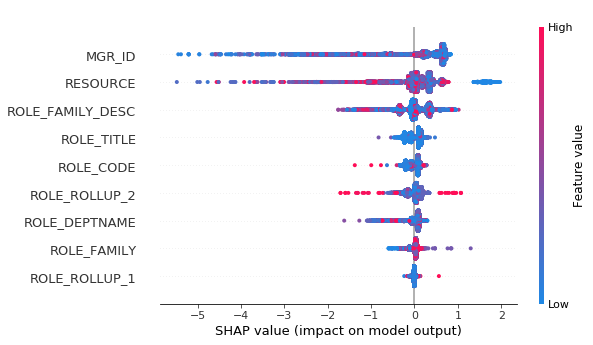

In [215]:
import shap
shap.initjs()
shap.summary_plot(shap_values[:,:-1], X)

** Question 14: **

What is the most important feature for 91-th object

In [210]:
shap_values[91,:-1]

array([-3.3277, -0.4636, -0.014 , -0.3015,  0.0948, -0.3666, -0.1977,
        0.0088, -0.2613])

In [211]:
most_important_feature = X.columns[abs(shap_values[91,:-1]).argmax()]
grader.submit_tag('most_important', most_important_feature)

Current answer for task most_important is: RESOURCE


** Question 15: **

Does it have positive or negative influence? Answer 1 if positive and -1 if negative.

In [212]:
influence_sign = -1
grader.submit_tag('shap_influence', influence_sign)

Current answer for task shap_influence is: -1


You can also view aggregated information about the influences on the whole dataset.

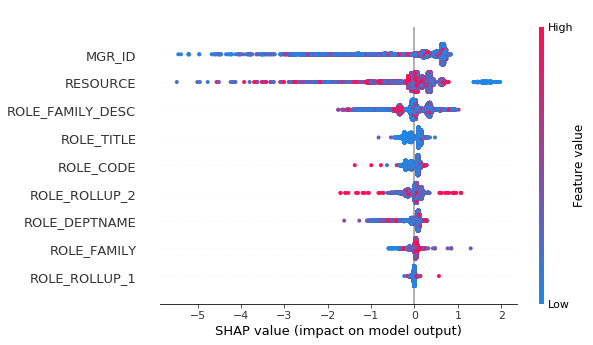

In [201]:
shap.summary_plot(shap_values[:,:-1], X)

From this graph you can see that values of MGR_ID and RESOURCE features have a large negative impact for many objects.
You can also see that RESOURCE has largest positive impact for many objects.

## Saving the model

You can save your model as a binary file. It is also possible to save the model as Python or C++ code.
If you save the model as a binary file you can then look on the parameters with which the model was trained, including learning_rate and random_seed that are set automatically if you don't specify them.

In [202]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')

In [203]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)
print(my_best_model.learning_rate_)

{'loss_function': 'Logloss', 'iterations': 10, 'logging_level': 'Silent', 'verbose': 0}
0
0.5


## Hyperparameter tunning

You can tune the parameters to get better speed or better quality.
Here is the list of parameters that are important for speed and accuracy.

### Training speed

Here is the list of parameters that are important for speeding up the training.
Note that changing this parameters might decrease the quality.
1. iterations + learning rate
By default we train for 1000 iterations. You can decrease this number, but if you decrease the number of iterations you need to increase learning rate so that the process converges. We set learning rate by default dependent on number of iterations and on your dataset, so you might just use default learning rate. But if you want to tune it, you need to know - the more iterations you have, the less should be the learning rate.

2. boosting_type
By default we use Ordered boosting for smaller datasets where we want to fight overfitting. This is expensive in terms of computations. You can set boosting_type to Plain to disable this.

3. bootstrap_type
By default we sample weights from exponential distribution. It is faster to use sampling from Bernoulli distribution. To enable that use bootstrap_type='Bernoulli' + subsample={some value < 1}

4. one_hot_max_size
By default we use one-hot encoding only for categorical features with little amount of different values. For all other categorical features we calculate statistics. This is expensive, and one-hot encoding is cheep. So you can speed up the training by setting one_hot_max_size to some bigger value

5. rsm
This parameter is very important, because it speeds up the training and does not affect the quality. So you should definitely use it, but only in case if you have hundreds of features.
If you have little amount of features it's better not to use this parameter.
If you have many features then the rule is the following: you decrease rsm, for example, you set rsm=0.1. With this rsm value the training needs more iterations to converge. Usually you need about 20% more iterations. But each iteration will be 10x faster. So the resulting training time will be faster even though you will have more trees in the resulting model.

6. leaf_estimation_iterations
This parameter is responsible for calculating leaf values after you have already selected tree structure.
If you have little amount of features, for example 8 or 10 features, then this place starts to be the bottle-neck.
Default value for this parameter depends on the training objective, you can try setting it to 1 or 5, and if you have little amount of features, this might speed up the training.

7. max_ctr_complexity
By default catboost generates categorical feature combinations in a greedy way.
This is time consuming, you can disable that by setting max_ctr_complexity=1 or by allowing only combinations of 2 features by setting max_ctr_complexity=2.
This will speed up the training only if you have categorical features.

8. If you are training the model on GPU, you can try decreasing border_count. This is the number of splits considered for each feature. By default it's set to 128, but you can try setting it to 32. In many cases it will not degrade the quality of the model and will speed up the training by a lot. 

In [ ]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    border_count=32)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)


** Question 16: **

Try tunning the speed of the algorithm. What is the maximum speedup you could get by changing these parameters without decreasing of AUC on best iteration on eval dataset compared to AUC on best iteration after training with default parameters and random seed = 0?
The answer shoud be a number, for example 2.7 means you got 2.7 times speedup.

In [204]:
speedup = 2.7
grader.submit_tag('speedup', speedup)

Current answer for task speedup is: 2.7


### Accuracy

The parameters listed below are important to get the best quality of the model. Try changing this parameters to improve the quality of the resulting model

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_validation, y_validation),
    plot=True
)

** Question 17: **

Try tunning these parameters to make AUC on eval dataset as large as possible. What is the maximum AUC value you have reached?

In [205]:
final_auc = 0.9
grader.submit_tag('final_auc', final_auc)

Current answer for task final_auc is: 0.9


In [213]:
STUDENT_EMAIL = 'youssef.skouri@esprit.tn'
STUDENT_TOKEN = 'kQl6a6Os9zMf7jBp'
grader.status()

You want to submit these numbers:
Task negative_samples: 1897
Task positive_samples: 30872
Task resource_unique_values: 7518
Task logloss_mean: 0.1381871029101599
Task logloss_std: 0.0008940612026746248
Task accuracy_6: 0.9539212694537686
Task best_model_name: learning_rate_0.05
Task num_trees: 100
Task mean_logloss_cv: 0.140862080899
Task logloss_std_1: 0.0055622410138
Task iterations_overfitting: 84
Task auc_550: 0.9849756977745989
Task feature_importance_top3: ['RESOURCE', 'MGR_ID', 'ROLE_DEPTNAME']
Task most_important: RESOURCE
Task shap_influence: -1
Task speedup: 2.7
Task final_auc: 0.9


In [214]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
